<a href="https://colab.research.google.com/github/mikonvergence/DiffusionFastForward/blob/master/02-colab-Pixel-Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
! git clone https://github.com/mikonvergence/DiffusionFastForward
! pip install pytorch-lightning diffusers einops kornia

Cloning into 'DiffusionFastForward'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 12), reused 37 (delta 9), pack-reused 0
Unpacking objects: 100% (43/43), 3.71 MiB | 5.76 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 426.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.4 MB/s eta 0:00:00


In [3]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xf maps.tar.gz
!rm maps.tar.gz

--2023-02-04 18:41:50--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   540KB/s    in 8m 8s   

2023-02-04 18:50:23 (501 KB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



# Unconditional Pixel Diffusion Training

In this notebook, we will train a simple `PixelDiffusion` model in low resolution (64 by 64).

The training should take about 10 hours.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
!rm maps.tar.gz
```

Ideally, you will download this dataset once and store it as `data/maps`. If you're running on colab, it's a good idea to download it once to your personal machine (it's only 240 MB) and then upload it to your colab space when you start a new notebook.

In [4]:
import sys
sys.path.append('./DiffusionFastForward/')

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

In [5]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair
        
        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )   
        
        # check files
        supported_formats=['webp','jpg']        
        self.files=[el for el in os.listdir(self.root_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image2,image
        else:
            return image

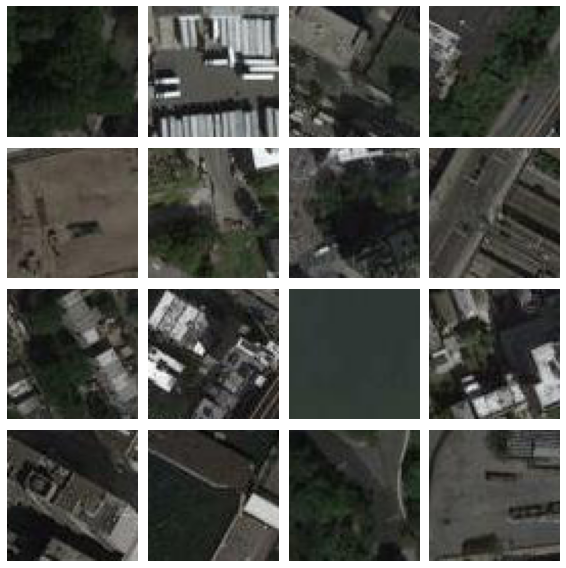

In [6]:
CROP_SIZE=64

inp_T=[        
        KA.RandomCrop((CROP_SIZE,CROP_SIZE)),
    ]

train_ds=SimpleImageDataset('./maps/train',
                            transforms=inp_T
                     )

test_ds=SimpleImageDataset('./maps/val',
                           transforms=inp_T
                          )

for idx in range(16):
    plt.subplot(4,4,1+idx)
    plt.imshow(train_ds[idx].permute(1,2,0))
    plt.axis('off')
plt.tight_layout()

### Model Training

In [7]:
model=PixelDiffusion(train_ds,
                     lr=1e-4,
                     batch_size=16)

Is Time embed used ?  True


In [8]:
trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    gpus = [0]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | DenoisingDiffusionProcess | 56.6 M
----------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.463   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
B=8 # number of samples

model.cuda()
out=model(batch_size=B,shape=(64,64),verbose=True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
B=8 # number of samples
STEPS=200 # ddim steps

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_size=B,sampler=ddim_sampler,shape=(64,64),verbose=True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')